In [1]:
# Standard Library
import datetime
import os
import re

# Third Party Library
import joblib
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from omegaconf import DictConfig, OmegaConf
from scipy.stats import rankdata
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# First Party Library
import src.configs.visualization_configs as vcfg
from src.utilities import find_project_root
from src.visualization import plot

In [2]:
plot.set_mpl_styles(fontsize=10.5)

In [3]:
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]
markers = ["s", "D", "o", "p", "*", "h", "D", "8", "v", "x"]

model_name = "ClassifierReflectance"
# trained_datetime = "2023-07-21/20-18-22"
# extracted_datetime = datetime.datetime(2024, 12, 18, 16, 56, 50)
# image_size = 64
extracted_datetime = datetime.datetime(2024, 12, 20, 11, 18, 00)
image_size = 32


project_dir = find_project_root()

model_save_pardir = project_dir / "models" / "VBGMM"
feature_pardir = (
    project_dir
    / "reports"
    / "features"
    / model_name
    / extracted_datetime.strftime("%Y-%m-%d/%H-%M-%S")
)
feature_figure_pardir = (
    project_dir
    / "reports"
    / "figures"
    / model_name
    / extracted_datetime.strftime("%Y-%m-%d/%H-%M-%S")
)
vbgmm_figure_pardir = (
    project_dir
    / "reports"
    / "figures"
    / "VBGMM"
    / extracted_datetime.strftime("%Y-%m-%d/%H-%M-%S")
)
image_pardir = (
    project_dir
    / f"data/processed/CNTForest/cnt_sem_{image_size}x{image_size}/10k/"
)

feature_train_csv_path = feature_pardir / "features_train_data.csv"
feature_check_csv_path = feature_pardir / "features_check_data.csv"

extraction_cfg = vcfg.ExtractionModelConfig(
    model_name, image_size, extracted_datetime.strftime("%Y-%m-%d/%H-%M-%S")
)

In [4]:
df_train = pl.read_csv(feature_train_csv_path)
X_train = df_train.select(
    pl.exclude(["target", "prediction", "filename", "dirname"])
).to_numpy()
metadata_train = df_train.select(pl.exclude(r"^column_\d+$")).with_row_count("id")
metadata_train.head()

id,target,prediction,dirname,filename
u32,i64,i64,i64,str
0,0,0,3,"""10k_3_h000_w00…"
1,0,0,3,"""10k_3_h000_w00…"
2,0,0,3,"""10k_3_h000_w00…"
3,0,0,3,"""10k_3_h000_w00…"
4,0,0,3,"""10k_3_h000_w00…"


In [5]:
df_check = pl.read_csv(feature_check_csv_path)
X_check = df_check.select(
    [pl.exclude(["target", "prediction", "filename", "dirname"])]
).to_numpy()
metadata_check = df_check.select(pl.exclude(r"^column_\d+$")).with_row_count("id")
metadata_check.head()

id,target,prediction,dirname,filename
u32,i64,i64,i64,str
0,0,0,3,"""10k_3_h000_w00…"
1,0,0,3,"""10k_3_h000_w00…"
2,0,0,3,"""10k_3_h000_w00…"
3,0,0,3,"""10k_3_h000_w00…"
4,0,0,3,"""10k_3_h000_w01…"


In [6]:
sc = StandardScaler()
minmax = MinMaxScaler((-1, 1))
pca = PCA(random_state=42)

X_train_std = sc.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_std)
X_train_pca_minmax = minmax.fit_transform(X_train_pca)

X_check_std = sc.transform(X_check)
X_check_pca = pca.transform(X_check_std)
X_check_pca_minmax = minmax.transform(X_check_pca)

threshold = 0.7
cumsum_contrb_rate = pca.explained_variance_ratio_.cumsum()
max_index_thresh = np.where(cumsum_contrb_rate - threshold > 0, 1, 0).argmax()
num_use_features = max_index_thresh + 1
print(num_use_features)

1


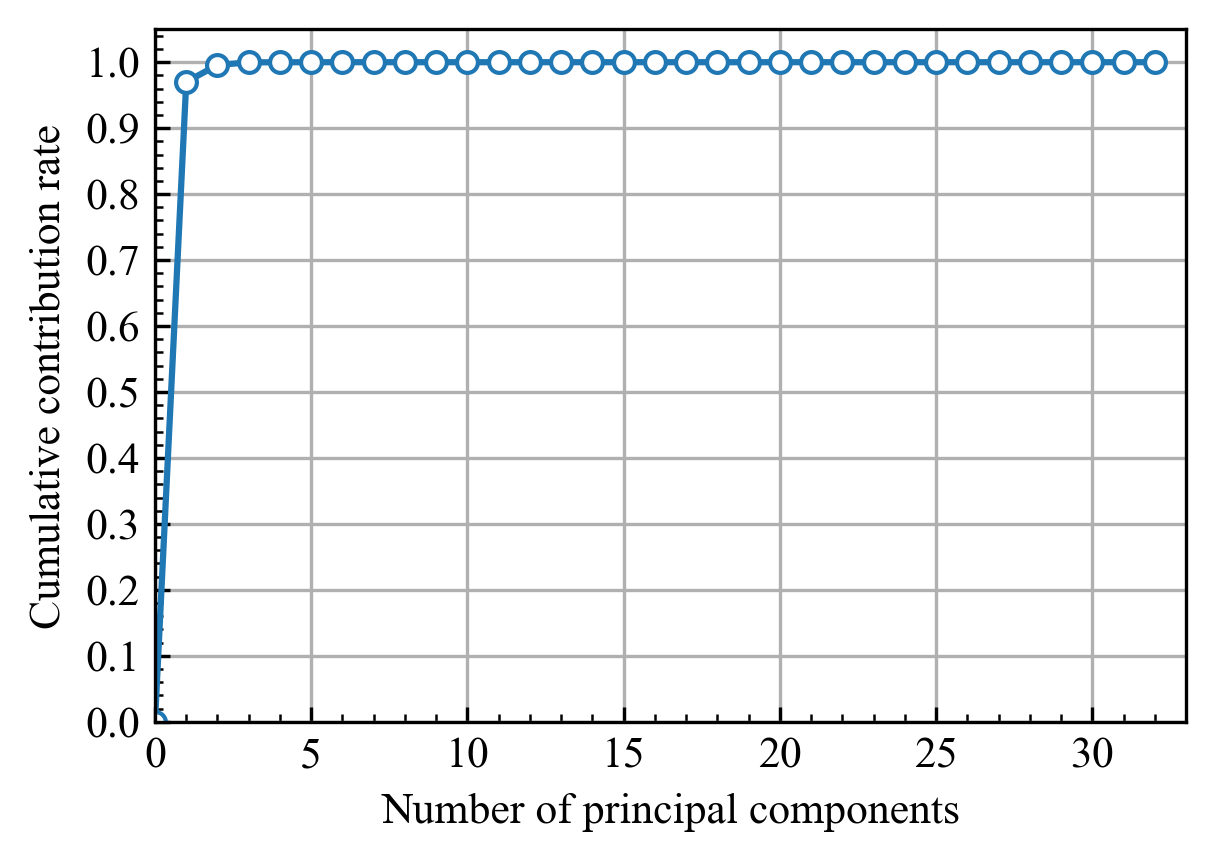

In [12]:
num_all_components = X_train.shape[1]
figsize_cm = [10, 7]
figsize=plot.cvt_unit(figsize_cm)

fig = plt.figure(figsize=figsize, layout="constrained", dpi=300)
ax = fig.add_subplot(1, 1, 1)

*_, lines, _ = plot.plot_cumulative_contribution_rate(
    cumsum_contrb_rate,
    ax,
    cumulated=True,
    threshold=threshold,
    # show_threshold=True,
)
lines[0].set_markerfacecolor("white")
lines[0].set_markersize(5)
if not feature_figure_pardir.exists():
    feature_figure_pardir.mkdir(parents=True)

# fig.savefig(feature_figure_pardir / "contribution_rate.svg", bbox_inches="tight")

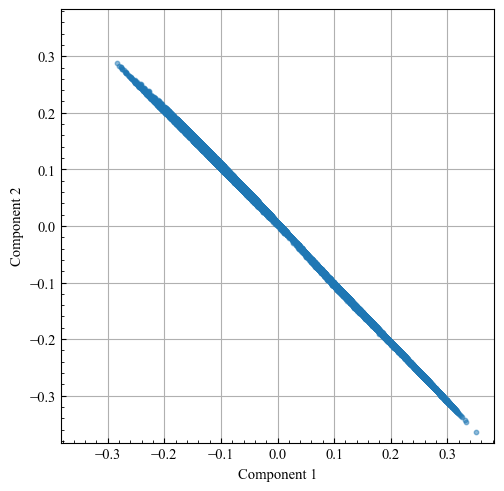

In [13]:
component_01 = df_train.select(
    [pl.col("column_0"), pl.col("column_1")]
).to_numpy()

# fig = plt.figure(layout="constrained")
# ax = fig.add_subplot(1,1,1)
# plot_scatter(ax, component_01.T)
# ax.set_xlabel("Component 1")
# ax.set_ylabel("Component 2")
fig, ax, _ = plot.plot_scatter(
    component_01.T,
    size=10,
    axis_labels=("Component 1", "Component 2"),
    color="tab:blue",
)

Text(0, 0.5, 'PC2')

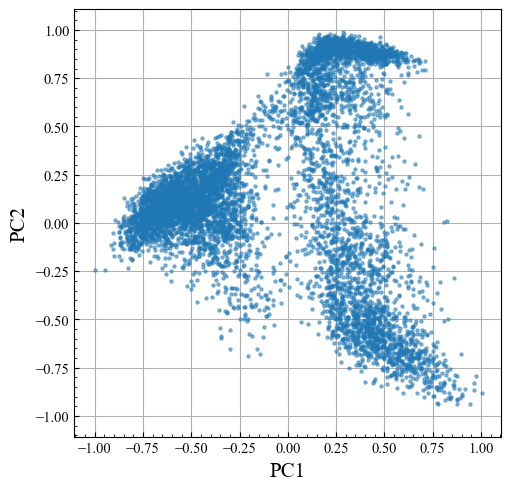

In [14]:
label_names = ("PC1", "PC2")
fig, ax, _ = plot.plot_scatter(
    X_check_pca_minmax.T,
    size=5,
)
ax.set_xlabel(label_names[0], fontsize=15)
ax.set_ylabel(label_names[1], fontsize=15)

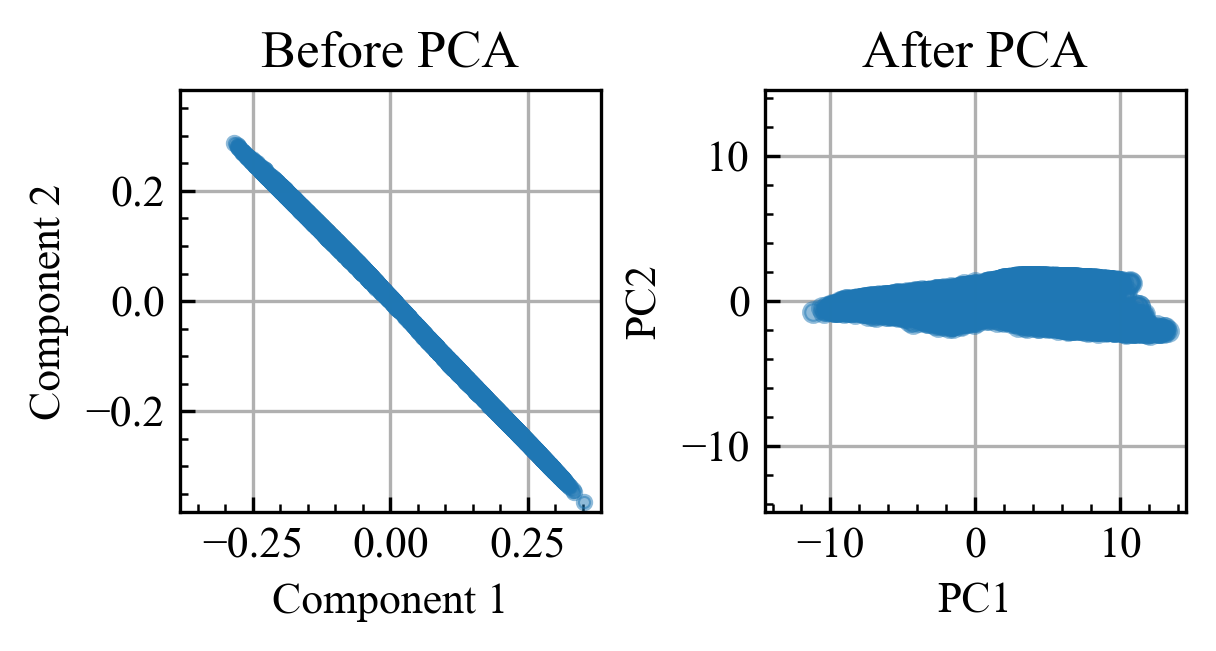

In [15]:
figsize_cm = [10, 7]
figsize=plot.cvt_unit(figsize_cm)
fig = plt.figure(figsize=figsize, layout="constrained", dpi=300)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.set_title("Before PCA")
ax2.set_title("After PCA")

plot.plot_scatter(
    X_train.T, axis_labels=("Component 1", "Component 2"), ax=ax1, size=10,
)
plot.plot_scatter(X_train_pca.T, axis_labels=("PC1", "PC2"), ax=ax2)


if not feature_figure_pardir.exists():
    feature_figure_pardir.mkdir(parents=True)
# fig.savefig(
#     feature_figure_pardir / "distribution_before-after_PCA.png",
#     dpi=300,
#     bbox_inches="tight",
# )

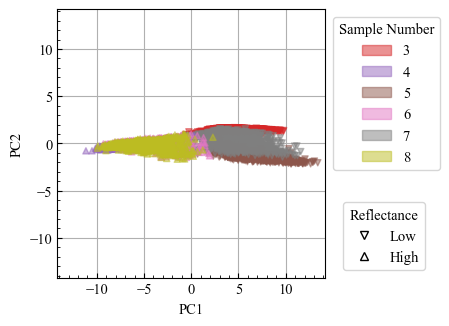

In [16]:
fig = plot.plot_scatter_reflclsf_features(
    X_check_pca,
    metadata_check,
    plotting_dims=(0, 1),
    is_pca_data=True,
    # is_rescaled_data=True
)

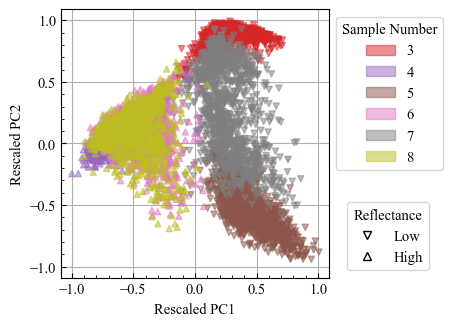

In [18]:
fig = plot.plot_scatter_reflclsf_features(
    X_check_pca_minmax,
    metadata_check,
    figsize_cm=(14, 8),
    plotting_dims=(0, 1),
    is_pca_data=True,
    is_rescaled_data=True
)

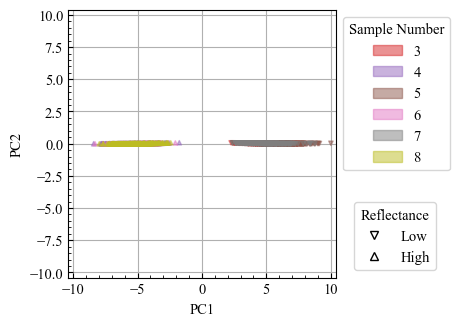

In [11]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

targets = metadata_check.select("target").unique().to_series().to_list()
# low_ref_cmap = plt.get_cmap("Blues")
# high_ref_cmap = plt.get_cmap("Reds")
cmap = plt.get_cmap("tab10")
markers = ["v", "^", "d", "v"]
target_label = {0: "Low", 1: "High"}
figsize_cm = [14, 8]
figsize=plot.cvt_unit(figsize_cm)

fig = plt.figure(figsize=figsize, layout="constrained", dpi=100)
ax = fig.add_subplot()
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_aspect("equal")
for t in targets:
    target_df = metadata_check.filter(pl.col("target") == t)

    color_id_with_dirname = target_df.unique("dirname").with_row_count("cid")

    # cmap = plt.get_cmap(
    #     "Blues" if t == 0 else "Reds", len(color_id_with_dirname)
    # )

    colors = [
        # cmap(cid) for cid in target_df.join(color_id_with_dirname, "dirname").select("cid").to_series().to_list()
        cmap(d) for d in target_df.select("dirname").to_series().to_list()
    ]

    idxes = target_df.select("id").to_series().to_list()

    plot.plot_scatter(
        X_check_pca[idxes].T,
        ax,
        size=10,
        color=colors,
        ploting_axes=(0, 2),
        marker=markers[t],
        scatter_label=t,
    )

sample_legend_elems = [
    Patch(color=cmap(d), label=d, alpha=0.5)
    for d in df_check.select("dirname").unique()[:, 0]
]
target_legend_elms = [
    Line2D(
        [0],
        [0],
        marker=markers[t],
        linestyle="",
        markeredgecolor="black",
        markerfacecolor="none",
        label=target_label[t],
    )
    for t in targets
]

target_legend = ax.legend(
    handles=target_legend_elms,
    title="Reflectance",
    loc="lower left",
    bbox_to_anchor=(1.04, 0.0),
)
sample_id_legend = ax.legend(
    handles=sample_legend_elems,
    title="Sample Number",
    loc="upper left",
    bbox_to_anchor=(1, 1),
)
ax.add_artist(target_legend)


if not feature_figure_pardir.exists():
    feature_figure_pardir.mkdir(parents=True)
# for ext in {"svg", "png"}:
#     fig.savefig(
#         feature_figure_pardir / f"pca_scatter.{ext}",
#         dpi=300,
#         bbox_inches="tight",
#     )

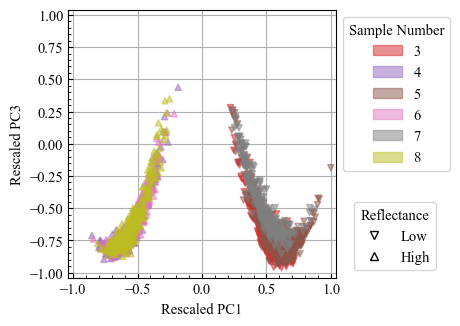

In [13]:
targets = metadata_check.select("target").unique()[:, 0]
cmap = plt.get_cmap("tab10")
markers = ["v", "^", "d", "v"]
target_label = {0: "Low", 1: "High"}
figsize_cm = [14, 8]
figsize=plot.cvt_unit(figsize_cm)
ploting_axes = (0, 2)
axis_labels = tuple(f"PC{i+1}" for i in range(0, X_check.shape[1]) if i in ploting_axes)

fig = plt.figure(figsize=figsize, layout="constrained", dpi=100)
ax = fig.add_subplot()

ax.set_xlabel(f"Rescaled {axis_labels[0]}")
ax.set_ylabel(f"Rescaled {axis_labels[1]}")
ax.set_aspect("equal")
ax.set_axisbelow(True)
for t in targets:
    target_df = metadata_check.filter(pl.col("target") == t)
    dirnames = target_df.select("dirname").to_numpy().flatten()
    colors = [cmap(d) for d in dirnames]
    idxes = target_df.select("id").to_numpy().flatten().tolist()
    plot.plot_scatter(
        X_check_pca_minmax[idxes].T,
        ax,
        color=colors,
        marker=markers[t],
        ploting_axes=(0, 2),
        scatter_label=t,
    )

# legend
sample_legend_elems = [
    Patch(color=cmap(d), label=d, alpha=0.5)
    for d in metadata_check.select("dirname").unique()[:, 0]
]
target_legend_elms = [
    Line2D(
        [0],
        [0],
        marker=markers[t],
        linestyle="",
        markeredgecolor="black",
        markerfacecolor="none",
        label=target_label[t],
    )
    for t in targets
]

target_legend = ax.legend(
    handles=target_legend_elms,
    title="Reflectance",
    loc="lower left",
    bbox_to_anchor=(1.04, 0.0),
)
sample_id_legend = ax.legend(
    handles=sample_legend_elems,
    title="Sample Number",
    loc="upper left",
    bbox_to_anchor=(1, 1),
)
ax.add_artist(target_legend)


if not feature_figure_pardir.exists():
    feature_figure_pardir.mkdir(parents=True)
# for ext in {"svg", "png"}:
#     fig.savefig(
#         feature_figure_pardir / f"rescaled_pca_scatter.{ext}",
#         dpi=300,
#         bbox_inches="tight",
#     )

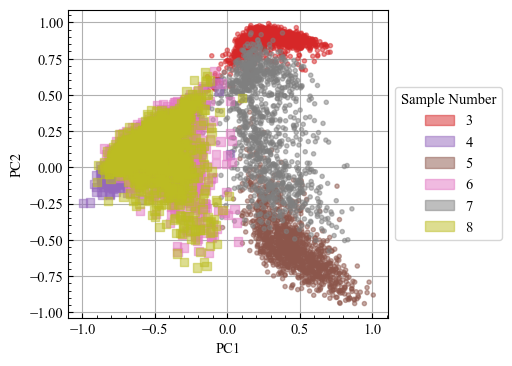

In [25]:
from matplotlib.patches import Patch

targets = df_check.select("target").unique()[:, 0]
cmap = plt.get_cmap("tab10")
markers = [".", "s", "d", "v"]

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()
for t in targets:
    target_df = df_check.filter(pl.col("target") == t)
    dirnames = target_df.select("dirname").to_numpy().flatten()
    colors = [cmap(d) for d in dirnames]
    idxes = target_df.select("row_nr").to_numpy().flatten().tolist()
    scatter = ax.scatter(
        X_check_pca_minmax[idxes, 0],
        X_check_pca_minmax[idxes, 1],
        color=colors,
        marker=markers[t],
        alpha=0.5,
        label=t,
    )

sample_legend_elems = [
    Patch(color=cmap(d), label=d, alpha=0.5)
    for d in df_check.select("dirname").unique()[:, 0]
]

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_aspect("equal")
ax.legend(
    handles=sample_legend_elems,
    title="Sample Number",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

# if not contrate_save_dst.exists():
#     contrate_save_dst.mkdir(parents=True)
# fig.savefig(
#     contrate_save_dst / "rescaled_pca_scatter.png",
#     dpi=300,
#     bbox_inches="tight",
# )

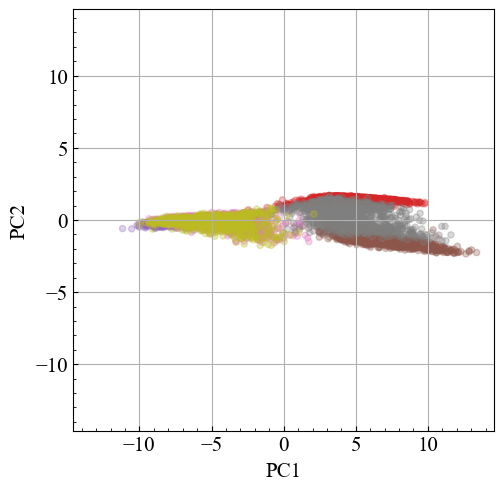

In [56]:
fig, ax, pc = plot.plot_scatter(X_check_pca.T, axis_labels=("PC1", "PC2"))

(matplotlib.axes._axes.Axes, {})

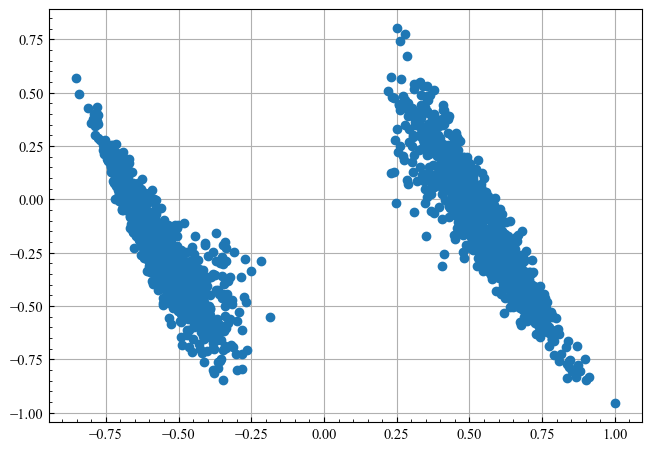

In [19]:
fig = plt.figure(figsize=(6.4, 4.4), layout='constrained', dpi=100)
ax = fig.add_subplot()
ax.scatter(
    X_check_pca_minmax[:, 0],
    X_check_pca_minmax[:, 1],
    # X_check_pca_minmax[:, 2],
)
ax._projection_init

In [47]:
clusterized_datetime = datetime.datetime.now()
nc = 4
max_iter = 1000

clustering_type = f"vbgmm_pca_{num_use_features}_{nc}clusters"
print(clustering_type)

vbgmm_train_pca = BayesianGaussianMixture(
    n_components=nc,
    max_iter=max_iter,
    n_init=10,
    init_params="k-means++",
    verbose=1,
    verbose_interval=50,
    random_state=42,
)
y_train_pca = vbgmm_train_pca.fit_predict(X_train_pca[:, :num_use_features])

vbgmm_pca_4_4clusters
Initialization 0
  Iteration 50
  Iteration 100
  Iteration 150
  Iteration 200
  Iteration 250
  Iteration 300
  Iteration 350
  Iteration 400
  Iteration 450
  Iteration 500
Initialization converged.
Initialization 1
  Iteration 50
Initialization converged.
Initialization 2
  Iteration 50
  Iteration 100
Initialization converged.
Initialization 3
  Iteration 50
  Iteration 100
  Iteration 150
  Iteration 200
  Iteration 250
Initialization converged.
Initialization 4
  Iteration 50
  Iteration 100
  Iteration 150
  Iteration 200
  Iteration 250
  Iteration 300
  Iteration 350
  Iteration 400
  Iteration 450
  Iteration 500
  Iteration 550
  Iteration 600
Initialization converged.
Initialization 5
  Iteration 50
  Iteration 100
Initialization converged.
Initialization 6
  Iteration 50
  Iteration 100
Initialization converged.
Initialization 7
  Iteration 50
  Iteration 100
Initialization converged.
Initialization 8
  Iteration 50
  Iteration 100
  Iteration 150
  

In [48]:
rank_of_cluster_train_pca = (
    rankdata(
        np.histogram(y_train_pca, bins=nc, range=(0, nc))[0], method="ordinal"
    )
    - 1
)
y_train_pca_sorted_cluster = rank_of_cluster_train_pca[y_train_pca]

In [49]:
rank_of_cluster_train_pca

array([3, 1, 2, 0])

In [50]:
# clusterized_datetime = datetime.datetime.now()
clustering_cfg = vcfg.ClusteringModelConfig(
    clustering_type,
    max_iter,
    int(num_use_features),
    nc,
    clusterized_datetime.strftime("%Y-%m-%d/%H-%M-%S"),
)

clstdt_str = clusterized_datetime.strftime("%Y-%m-%d/%H-%M-%S")
model_save_dir = model_save_pardir / clstdt_str

if not model_save_dir.exists():
    os.makedirs(model_save_dir)
joblib.dump(
    vbgmm_train_pca, model_save_dir / f"{clustering_type}_iter{max_iter}.pkl"
)

oconf: DictConfig = OmegaConf.structured(
    vcfg.VisConfigs(extraction_cfg, clustering_cfg)
)
with open(model_save_dir / "config.yaml", "w") as f:
    f.writelines(OmegaConf.to_yaml(oconf))

Text(0, 0.5, 'weight of each component')

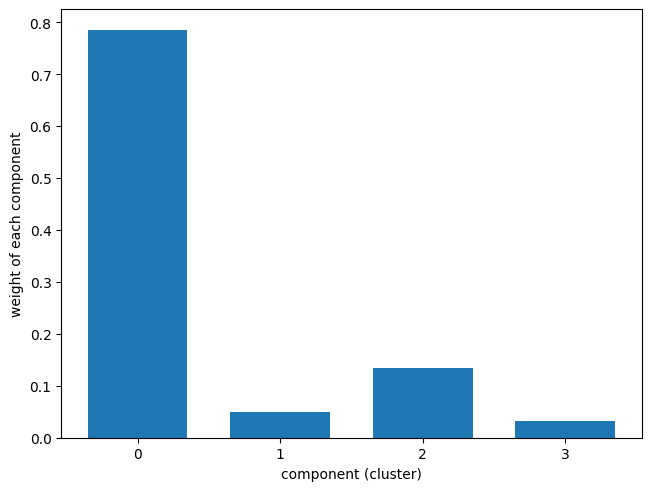

In [51]:
clusters = tuple(range(nc))
fig = plt.figure(layout="constrained")
ax = fig.add_subplot(1, 1, 1)
ax.bar(clusters, vbgmm_train_pca.weights_, width=0.7, tick_label=clusters)
ax.set_xlabel("component (cluster)")
ax.set_ylabel("weight of each component")

(<Axes: xlabel='Cluster number', ylabel='Count of cluster'>,
 <BarContainer object of 4 artists>)

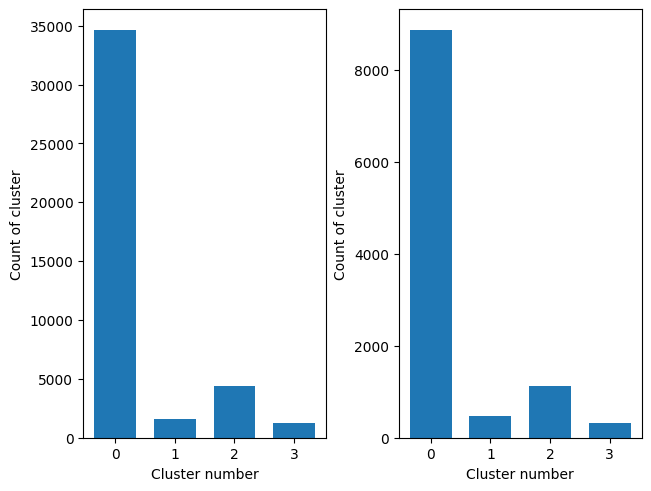

In [52]:
y_check_pca = vbgmm_train_pca.predict(X_check_pca[:, :num_use_features])
y_check_pca_sorted_cluster = rank_of_cluster_train_pca[y_check_pca]

fig = plt.figure(layout="constrained")
axr = fig.add_subplot(1, 2, 1)
axl = fig.add_subplot(1, 2, 2)
plot.plot_bar(
    y_train_pca,
    ax=axr,
    label_names=("Cluster number", "Count of cluster"),
    num_bins=nc,
)
plot.plot_bar(
    y_check_pca,
    ax=axl,
    label_names=("Cluster number", "Count of cluster"),
    num_bins=nc,
)

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

(-26.270786362880784, 3.9528659456793305)
(-5.221441133286326, 20.03703263592064)
(-20.03703263592064, 20.03703263592064)
(-20.03703263592064, 20.03703263592064)
(-20.03703263592064, 20.03703263592064)
(-20.03703263592064, 20.03703263592064)
(-20.03703263592064, 20.03703263592064)
(-20.03703263592064, 20.03703263592064)


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

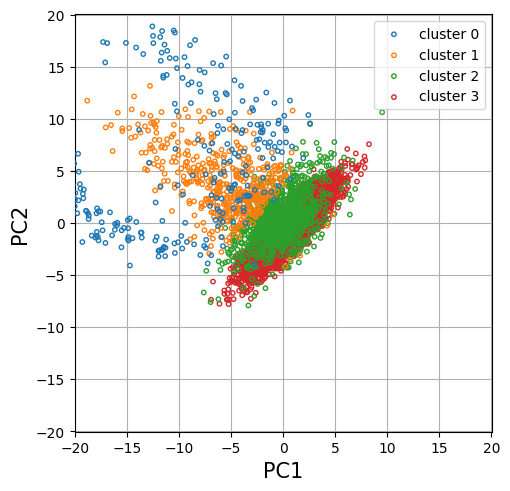

In [79]:
fig = plt.figure(layout="constrained")
ax = fig.add_subplot()
cmap = plt.get_cmap("tab10")
for c in np.unique(y_check_pca_sorted_cluster):
    mask = y_check_pca_sorted_cluster == c
    X_masked = X_check_pca[mask, :2].T
    _, pc = plot.plot_scatter(
        X_masked,
        ax,
        size=10,
        color=cmap(c),
    )
    pc.set_label(f"cluster {c}")
    pc.set_zorder(nc - c)
ax.set_xlabel(label_names[0], fontsize=15)
ax.set_ylabel(label_names[1], fontsize=15)

ax.legend()
ax.grid()
ax.set_axisbelow(True)

In [54]:
make_file_path_col = pl.concat_str(
    [pl.col("dirname"), pl.col("filename")], separator="/"
).alias("filepath")
train_features_pca = pl.concat(
    (
        pl.from_numpy(X_train_pca),
        df_train.select(make_file_path_col),
        pl.DataFrame({"cluster": y_train_pca_sorted_cluster}),
    ),
    how="horizontal",
)
clstdt_str = clusterized_datetime.strftime("%Y-%m-%d-%H-%M-%S")
train_features_pca.write_csv(
    feature_pardir / f"features_train_data_pca_with_clusters_{clstdt_str}.csv",
)

In [55]:
make_file_path_col = pl.concat_str(
    [pl.col("dirname"), pl.col("filename")], separator="/"
).alias("filepath")
check_features_pca = pl.concat(
    (
        pl.from_numpy(X_check_pca),
        df_check.select(make_file_path_col),
        pl.DataFrame({"cluster": y_check_pca_sorted_cluster}),
    ),
    how="horizontal",
)
clstdt_str = clusterized_datetime.strftime("%Y-%m-%d-%H-%M-%S")
check_features_pca.write_csv(
    feature_pardir / f"features_check_data_pca_with_clusters_{clstdt_str}.csv",
)

max_abs_range=32.00419246805015


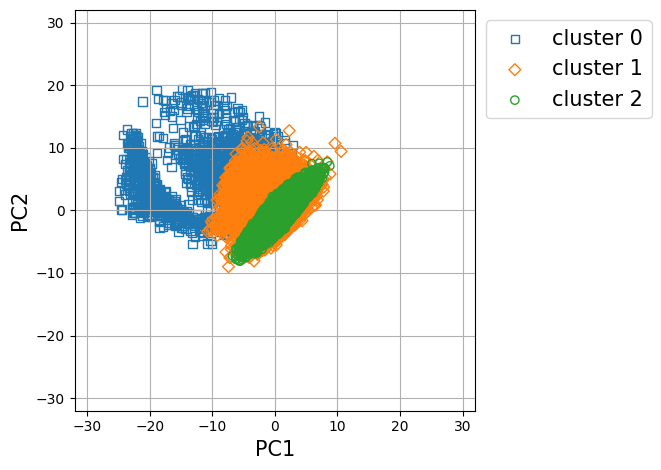

In [ ]:
plot.scatter_each_classes(
    X_train_pca,
    # cluster_labels,
    class_labels=y_train_pca_sorted_cluster - 1,
    rank=np.arange(0, 10),
    # y_train_pca,
    markers=markers,
    colors=colors,
    xylabel=("PC1", "PC2"),
    face_color="None",
    fontsize=15,
    # path=scatter_save_path,
    # path="../reports/figures/VBGMM/2023-07-14/cluster_images/scatter.png"
    # path = figure_pardir / f"cluster_images_iter{max_iter}" / f"scatter_iter{max_iter}.png"
)

In [32]:
figure_pardir

PosixPath('/home/shinsei/MyResearches/feat_extrc/reports/figures/VBGMM/2023-11-27/12-07-16')

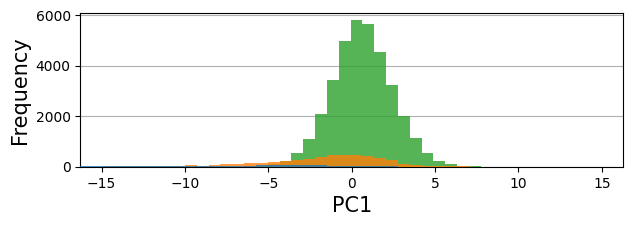

In [42]:
x_min = -16.268626574593476
x_max = 16.268626574593476
fontsize = 15

df_pc1 = pl.DataFrame(X_train_pca[:, 0]).with_columns(
    train_features_pca.select([pl.col("cluster")])
)

min_max = (
    df_pc1.select(pl.col("column_0"))
    .describe()
    .filter((pl.col("describe") == "max") | (pl.col("describe") == "min"))
    .select(pl.col("column_0"))
    .to_numpy()
    .flatten()
)

fig = plt.figure(figsize=(7, 2))
ax = fig.add_subplot(1, 1, 1)

for i in range(10):
    pc1 = (
        df_pc1.filter(pl.col("cluster") == i)
        .select("column_0")
        .to_numpy()
        .flatten()
    )

    ax.hist(
        pc1,
        bins=50,
        range=min_max,
        alpha=0.8,
        label=f"cluster_{i}",
        zorder=10 - i,
    )
ax.set_xlim(x_min, x_max)
ax.set_ylim(
    0,
)

ax.set_xlabel("PC1", fontsize=fontsize)
ax.set_ylabel("Frequency", fontsize=fontsize)
ax.grid(axis="y")

# fig.savefig(
#     fname=figure_pardir / f"cluster_images_iter{max_iter}" / "frequency_pc1.png",
#     dpi=fig.get_dpi(),
#     bbox_inches="tight"
# )

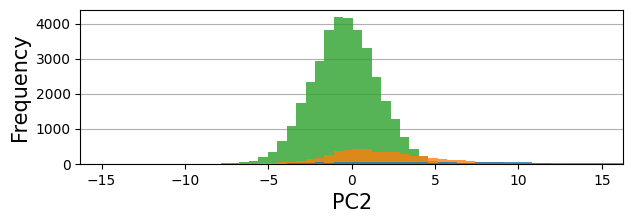

In [46]:
df_pc2 = pl.DataFrame(X_train_pca[:, 1]).with_columns(
    train_features_pca.select([pl.col("cluster")])
)

min_max = (
    df_pc2.select(pl.col("column_0"))
    .describe()
    .filter((pl.col("describe") == "max") | (pl.col("describe") == "min"))
    .select(pl.col("column_0"))
    .to_numpy()
    .flatten()
)

fig = plt.figure(figsize=(7, 2))
ax = fig.add_subplot(1, 1, 1)

for i in range(10):
    pc1 = (
        df_pc2.filter(pl.col("cluster") == i)
        .select("column_0")
        .to_numpy()
        .flatten()
    )

    ax.hist(
        pc1,
        bins=50,
        range=min_max,
        alpha=0.8,
        label=f"cluster_{i}",
        zorder=10 - i,
    )
ax.set_xlim(x_min, x_max)
ax.set_ylim(
    0,
)

ax.set_xlabel("PC2", fontsize=fontsize)
ax.set_ylabel("Frequency", fontsize=fontsize)
ax.grid(axis="y")
# fig.savefig(
#     fname=figure_pardir / f"cluster_images_iter{max_iter}" / "frequency_pc2.png",
#     dpi=fig.get_dpi(),
#     bbox_inches="tight"
# )

In [18]:
model_save_dir

PosixPath('/home/shinsei/MyResearchs/feat_extrc/models/VBGMM/2023-07-10/13-09-32')